# Trace Objects Task

Seosamh O Roibin

Beginning with importation of geopandas 

In [72]:
import pandas
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import json
import networkx as nx
from networkx.readwrite import json_graph

Reading in shape file for cables and joints

In [4]:
cables = gpd.read_file('./Sample_Data/cables.shp')
joints = gpd.read_file('./Sample_Data/joints.shp')

Visualise the cables and joints as graph 

Text(0.5, 1.0, 'Visualisation of Cables & Joints')

<Figure size 432x288 with 0 Axes>

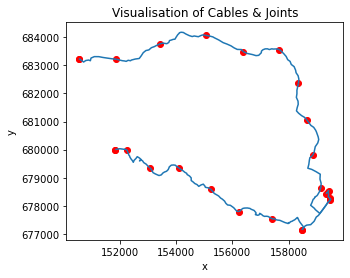

In [5]:
fig = plt.figure()
ax = cables.plot()  # Cables are the connections between the nodes
fig = joints.plot(ax = ax, color='red')  # Joints refer to the nodes 
fig.set_xlabel('x')
fig.set_ylabel("y")
fig.set_title('Visualisation of Cables & Joints')

Would like to take some of the distractions away from the data to work with, so will run selection operation on the columns in the data with which I will be working

In [10]:
filtered_cables_data = cables[['OBJECTID', 'GlobalID', 'o_AEND', 'o_BEND', 'geometry']]
filtered_cables_data.head()

,OBJECTID,GlobalID,o_AEND,o_BEND,geometry
0,1,{360BB121-85E1-40B7-AFF4-259A67F247B1},WSJUR_20_IJ_45,f8f4f87c-dc5b-47b9-bd0b-8339d897c0b3,"LINESTRING (157409.666 677539.484, 157337.069 ..."
1,2,{1BDDDD35-2D54-4A74-92C2-4B4EED581120},f8f4f87c-dc5b-47b9-bd0b-8339d897c0b3,101bcba8-19b7-401e-9fb0-f10a262f1755,"LINESTRING (156216.758 677796.712, 156157.279 ..."
2,3,{73684DA5-3E47-4239-BA54-1B46E8E63C6E},101bcba8-19b7-401e-9fb0-f10a262f1755,a8760718-4e76-4f7b-b381-fdc2fbec79b9,"LINESTRING (155217.926 678598.927, 155149.929 ..."
3,4,{B658B86A-22D2-4C85-9626-7A159869CE9B},a8760718-4e76-4f7b-b381-fdc2fbec79b9,071cbcd1-9c41-4024-930e-8009ef47751e,"LINESTRING (154091.311 679346.779, 154080.430 ..."
4,5,{E508ED26-B9BC-428E-AEE0-DABC2A1CD7C4},071cbcd1-9c41-4024-930e-8009ef47751e,10327ac8-29a9-466f-a01a-c81497e37b3b,"LINESTRING (153050.478 679362.652, 153003.387 ..."


In [79]:
filtered_joints_data = joints[['OBJECTID', 'o_ID', 'o_PARENT_I', 'GlobalID', 'spec', 'geometry']]
filtered_joints_data.head()

,OBJECTID,o_ID,o_PARENT_I,GlobalID,spec,geometry
0,1,WSJUR_20_CBT_L21_1,WSJUR_20_SN_4,{2E88DC1C-9E23-4417-B882-21695DBCA0E3},CBT4,POINT (159443.629 678545.185)
1,2,WSJUR_20_IJ_42,6079967f-9d89-4681-ac15-73e98f96406c,{2F628C39-C336-452C-B0CD-8741B0E88458},SMALL_NODE_AS_IJ,POINT (159147.714 678640.843)
2,3,WSJUR_20_CBT_16_1,WSJUR_20_IJ_44,{FEC3CD67-40DD-4724-8EF2-F4E265AE91EC},CBT4,POINT (158484.142 677143.085)
3,4,WSJUR_20_IJ_35,WSJUR_20_IJ_42,{4D72CFC9-356E-49EF-908E-2467A5DAE061},SMALL_NODE_AS_IJ,POINT (158849.904 679792.741)
4,5,WSJUR_20_SN_4,None,{06BE6B84-61F1-44B3-A712-4A7FADFAAEDC},SMALL_NODE_AS_SPN,POINT (159401.932 678507.163)


Lets interpret the data 
We have cables where AEND and BEND correspond with o_ID in JOINTS. 
In order to complete the task:
1) Take Node (Starting From WSJUR_20_SN_4)
2) Look up o_AEND in Cables WHERE o_AEND == o_ID
3) Using o_BEND Value in Cables See if Exists a value equal in o_AEND (This means theres a connection) 
4) If this is null, the connection ends. we return
5) We use dictionary structure, so perhaps we can use the parent node as our key and then push the children as values

I then decided to change back into a dataframe so that I could create an edge list for use in networkx. (Not necessary but wanted to show I can manipulate data) Needed to change columns name, transpose and reset the index. 

I then looped through the rows of the dataframe: now this is where I came to an issue, I was not able to find a way of using networkx to accept a scenario where the children is equal to null: so the edge list is comprised of only relations e.g. parent -> child; never an instance of parent -> [] (No descendents) which probably makes the answer I get wrong. 

I then use the pandas edge list function in networkx to convert it into a directed graph... I believe this is the correct graph to use based on my understanding of the data because we have an A-END and a B-END.  

We set the root_id to be equal to first entry (WSJUR_20_SN_4) 

I then use the json_graph.tree_data to take the created tree and convert into a json object. 

I investigated my results afterwards on QGIS and I am unsure if I have interpreted the data correctly and whether or not the extrapolated result is correct: I then perhaps my recursive function may not have taken into account the directed nature of the graph analysed. 




In [77]:
parent_child_relations = {}
extended_children_relations = {} 

def get_parent_child_relations(point):
    parent_point= cables[cables["o_AEND"] == point]
    if (parent_point.empty):
        parent_child_relations[point] = [""]
        return
    parent = parent_point["o_AEND"].head(1).values[0]
    children = parent_point["o_BEND"].values.tolist()
    parent_child_relations[parent] = [children]
    for point in children:
        get_parent_child_relations(point)

start_point = "WSJUR_20_SN_4"
get_parent_child_relations(start_point)

#cleansing the data by moving it from dictionary into dataframe, transposition and resetting the index and renaming the columns as per the parameters of the task 
df = pandas.DataFrame(data=parent_child_relations).T.reset_index()
df.rename(columns= {"index": "Name", 0: "Children"}, inplace=True)


for index, row in df.iterrows():
   # if row['Children'] == "":
      #  parent_child_list.append([row['Name'], " "])
    for child in row['Children']:
     parent_child_list.append([row['Name'], child])

edge_list = pandas.DataFrame(parent_child_list, columns = ['Name', 'children'])

# convert edge list in pandas over to network graph 
g = nx.from_pandas_edgelist(edge_list, 'Name', 'children', create_using=nx.DiGraph())
# asserting the first entry in df as root 
root_id = edge_list.loc[0, 'Name']    
out = [nx.tree_data(g, root_id, ident='Name', children='children')]
data = json_graph.tree_data(g,root=root_id)
print(data)


{'id': 'WSJUR_20_SN_4', 'children': [{'id': '6079967f-9d89-4681-ac15-73e98f96406c', 'children': [{'id': 'WSJUR_20_IJ_42', 'children': [{'id': 'WSJUR_20_IJ_35', 'children': [{'id': 'f614a73b-a59c-4ec4-82f7-c1f0a949c87d', 'children': [{'id': 'e841fbb7-5a33-4dff-b296-7d0187c7c9e2', 'children': [{'id': 'd7e8a93e-51f2-47f3-9b86-cbcb20661a73', 'children': [{'id': '2ded1da0-aafd-4d00-b4d3-9535fbe23fb1', 'children': [{'id': '1e539e0f-bb3f-427f-a4b5-811b3bcdcafd', 'children': [{'id': 'd3240ad0-47b8-423a-b609-6141e2c99665', 'children': [{'id': '0c381dd2-9bcc-43ed-b7cd-e23c94368cb0', 'children': [{'id': 'e34bef71-36e6-4a83-a09f-bf69d847ec79', 'children': [{'id': '1458f2da-bff4-4f12-acdf-36f2d9746025'}]}]}]}]}]}]}]}]}]}]}, {'id': 'WSJUR_20_CBT_14_1'}, {'id': 'WSJUR_20_IJ_44', 'children': [{'id': 'WSJUR_20_CBT_16_1'}, {'id': 'WSJUR_20_IJ_45', 'children': [{'id': 'f8f4f87c-dc5b-47b9-bd0b-8339d897c0b3', 'children': [{'id': '101bcba8-19b7-401e-9fb0-f10a262f1755', 'children': [{'id': 'a8760718-4e76-4f7